In [1]:
# Basic import necessary for configuration.
import os
import warnings
import requests

warnings.simplefilter("ignore", RuntimeWarning)

maindir = os.path.join(os.getcwd(), '../Data/')

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/fran/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


In [2]:
# ----------------------General Imports----------------------
import time
import glob
import json
import itertools
import numpy as np
import pandas as pd

# --------------------Astroquery Imports---------------------
from astroquery.mast import Observations

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import scienceplots
plt.style.use('science')

# -------------------File Download Imports-------------------
from tqdm.auto import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

In [3]:
sci_dir = os.path.join(maindir, f'data_01366/Obs003/')
uncal_dir = os.path.join(sci_dir, f'uncal/')
det1_dir = os.path.join(sci_dir, 'stage1/') 

os.makedirs(det1_dir, exist_ok=True)

In [4]:
# list files in uncal directory
rateints_files = glob.glob(det1_dir + '*6491*' + '*ints*')
print(f"Science UNCAL Files:\n{'-'*20}\n" + "\n".join(rateints_files))

Science UNCAL Files:
--------------------
/home/fran/OneDrive/BSc Project/Notebooks/../Data/data_01366/Obs003/stage1/jw06491001001_04101_00001-seg001_nrs1_rateints.fits


In [5]:
with fits.open(rateints_files[0]) as hdul:
    # Print the header information for the first HDU
    print(hdul.info())
    print(hdul[0].header)

Filename: /home/fran/OneDrive/BSc Project/Notebooks/../Data/data_01366/Obs003/stage1/jw06491001001_04101_00001-seg001_nrs1_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     250   ()      
  1  SCI           1 ImageHDU        63   (512, 32, 6058)   float32   
  2  ERR           1 ImageHDU        11   (512, 32, 6058)   float32   
  3  DQ            1 ImageHDU        12   (512, 32, 6058)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   6058R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (512, 32, 6058)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (512, 32, 6058)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [10907B]   
None
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions       

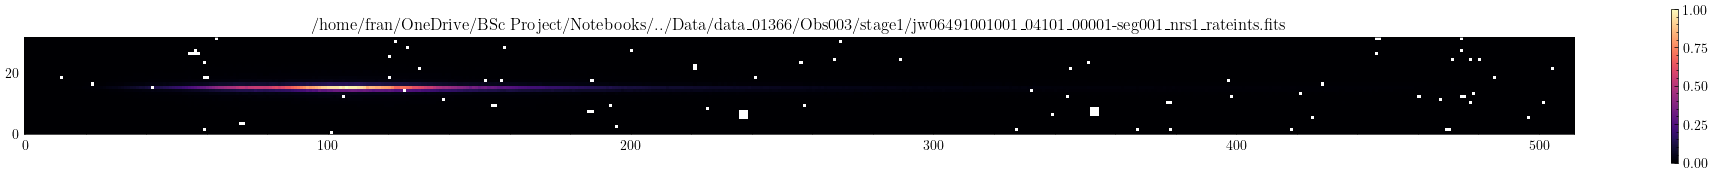

In [6]:
def plot_fits(file):
    with fits.open(file) as hdul:
        data = hdul[1].data
        #data = np.nansum(data, axis=0)
        data = data[3, :, :]
        # Normalize the data
        data = data / np.nanmax(data)
        # take only data where it is smaller than 0.05
        #data[data < 0] = 0
        #data[data > 0.0008] = 0.0008

        plt.figure(figsize=(25, 2))  # Make the figure square
        plt.imshow(data, cmap='magma', aspect='equal', origin='lower')
        plt.colorbar()
        plt.title(file)
        plt.show()

# Plot each file
for file in rateints_files:
    plot_fits(file)

In [7]:
def inject_radial_circle(array, plane_index, center_x, center_y, radius, value_range=(1e4, 1e7), falloff_power=3):
    """
    Injects a circular region of decreasing random values into a 3D array slice.

    Parameters:
        array (ndarray): 3D numpy array (e.g., data[plane_index, :, :]).
        plane_index (int): The index of the plane to modify.
        center_x (int): Row coordinate of the circle center.
        center_y (int): Column coordinate of the circle center.
        radius (int): Radius of the circle in pixels.
        value_range (tuple): Tuple of (min, max) random values to scale with falloff.
        falloff_power (float): Exponent to control decay shape (e.g., 1 = linear, 2 = quadratic, 3 = cubic).
    """
    for i in range(center_x - radius, center_x + radius + 1):
        for j in range(center_y - radius, center_y + radius + 1):
            dy = i - center_x
            dx = j - center_y
            dist = np.sqrt(dx**2 + dy**2)
            if dist <= radius:
                falloff = 1 - (dist / radius) + 1e-1
                base_value = np.random.uniform(*value_range)
                array[plane_index, i, j] = base_value * (falloff ** falloff_power)

In [8]:
import deadpixl as dp

CRDS local filepath: /home/fran/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


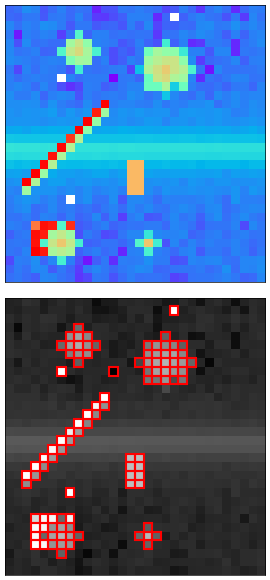

In [9]:
with fits.open(rateints_files[0]) as hdul:
    data = hdul[1].data
    original_data = np.log10(abs(data[153, :, 210:220]))

    # Introduce random values for testing
    data[153, 3:7, 253:258] = np.random.uniform(1e3, 1e10, size=(4, 5))

    # Generate a 45-degree diagonal line of high values
    for i in range(10):
        data[153, 10+i, 252+i] = np.random.uniform(1e5, 1e6)
        data[153, 11+i, 252+i] = np.random.uniform(1e3, 1e10)

    data[153, 10:14, 264:266] = 2e7

    inject_radial_circle(data, 153, 24, 268, 3)
    inject_radial_circle(data, 153, 4, 256, 2)
    inject_radial_circle(data, 153, 4, 266, 1)
    inject_radial_circle(data, 153, 26, 258, 2)

    data_slice = data[153, :, 250:280]

    # Find dead pixels
    dead_pixels = dp.find_dead_pixels(data_slice, 1.5)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)

    # First plot: no overlays
    axes[0].imshow(np.log10(abs(data_slice)), cmap='rainbow', aspect='equal', origin='lower')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Second plot: with dead pixel boxes
    axes[1].imshow(np.log10(abs(data_slice)), cmap='grey', aspect='equal', origin='lower')
    for pixel in dead_pixels:
        x, y = pixel
        rect = plt.Rectangle((y - 0.5, x - 0.5), 1, 1, edgecolor='red', facecolor='none', lw=1.5)
        axes[1].add_patch(rect)

    # Add colorbar to the right of both plots
    plt.tight_layout()
   # plt.savefig(f"../Presentations/Introduction Presentation/Pictures/identification.pdf", bbox_inches='tight', dpi=300)
    plt.show()


[[ 0.57037926  0.6565633   0.624603   ...  0.5516777   1.0400946
   1.0525656 ]
 [ 1.1885669   0.8382167   0.82669544 ...  0.9742416   1.0437934
   1.3323565 ]
 [ 0.74100333  1.2759944  -0.51550156 ...  0.8562416   1.0929322
   0.42283794]
 ...
 [ 0.7393503   0.5511813   0.6001334  ...  1.1772478   1.1427238
   1.1051744 ]
 [ 1.276685   -0.2142305   0.5821427  ...  0.40298823  1.0905985
   0.9625929 ]
 [ 0.971163    1.1904875   0.7806127  ...  1.0727669   1.1753728
   1.2173002 ]]


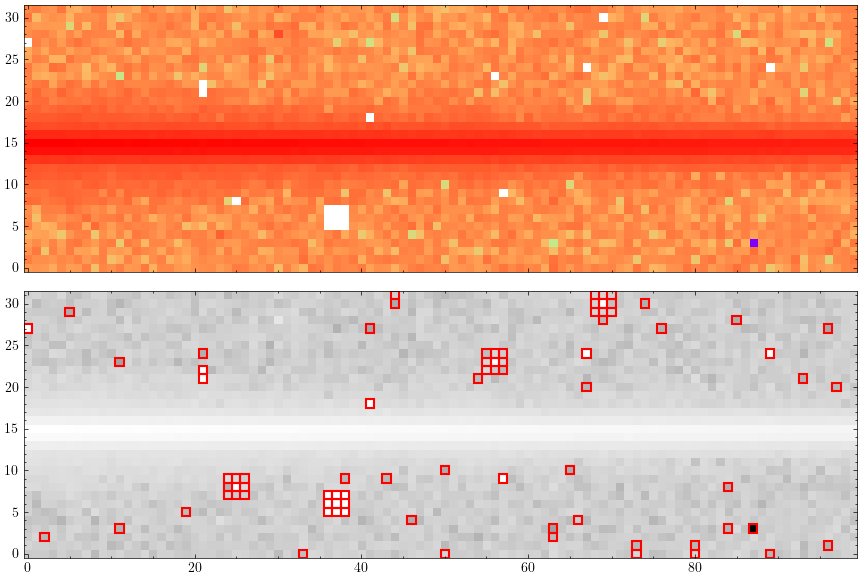

In [70]:
with fits.open(rateints_files[0]) as hdul:
    data = hdul[1].data

    data_slice = data[9, :, 200:300]
    print(np.log10(abs(data_slice)))

    # Find dead pixels
    dead_pixels = dp.find_dead_pixels(data_slice, 1.5)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)

    # First plot: no overlays
    axes[0].imshow(np.log10(abs(data_slice)), cmap='rainbow', aspect='equal', origin='lower')
    #axes[0].set_xticks([])
    #axes[0].set_yticks([])

    # Second plot: with dead pixel boxes
    axes[1].imshow(np.log10(abs(data_slice)), cmap='grey', aspect='equal', origin='lower')
    for pixel in dead_pixels:
        x, y = pixel
        rect = plt.Rectangle((y - 0.5, x - 0.5), 1, 1, edgecolor='red', facecolor='none', lw=1.5)
        axes[1].add_patch(rect)

    # Add colorbar to the right of both plots
    plt.tight_layout()
   # plt.savefig(f"../Presentations/Introduction Presentation/Pictures/identification.pdf", bbox_inches='tight', dpi=300)
    plt.show()


In [11]:
def confidences(data, high_confidence_pixels):
    full_data = np.zeros(data.shape)

    #extract the values
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if (i,j) in high_confidence_pixels:
                full_data[i,j] = high_confidence_pixels[(i,j)]
            else:
                full_data[i,j] = np.nan

    return full_data

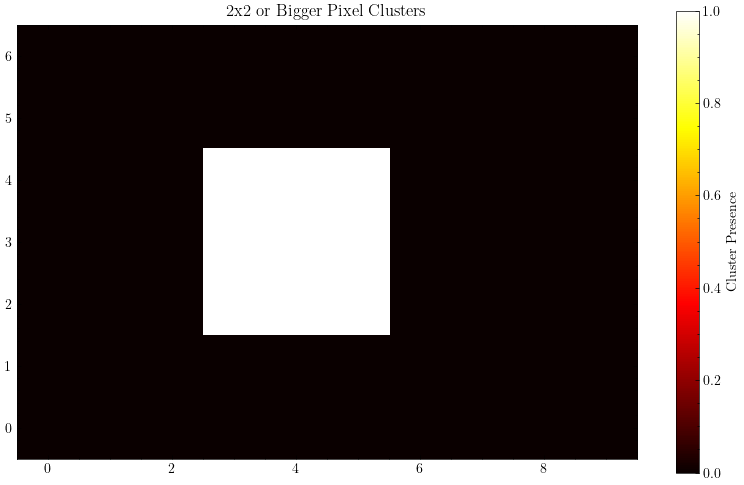

In [12]:
# Classify dead pixels into clusters
clusters = dp.classify_dead_pixels(dead_pixels)

# Filter clusters to include only those with size 4 or more (2x2 or bigger)
filtered_clusters = [cluster for cluster in clusters if len(cluster) >= 9]

# Create a blank mask for visualization
mask = np.zeros(data_slice.shape, dtype=int)

# Mark the filtered clusters on the mask
for cluster in filtered_clusters:
    for p in cluster:
        mask[p[0], p[1]] = 1

# Plot the mask
plt.figure(figsize=(10, 6))
plt.imshow(mask, cmap='hot', aspect='equal', origin='lower')
plt.title("2x2 or Bigger Pixel Clusters")
plt.colorbar(label="Cluster Presence")
plt.show()

In [301]:
pixels = dp.filter_pixels(rateints_files[0], threshold=1.5, slices=2, min_slices=2, debug_length=3000)

In [302]:
pixel_index = [p for pix in pixels for p in pix]
unique_pixel_index = [list(t) for t in set(tuple(p) for p in pixel_index)]
unique_pixel_index.sort()

In [303]:
import copy

pixel_values, pixel_labels, pixels_classified = [], [], []
for i, pix in enumerate(pixels):
    pix.sort()
    classified = dp.classify_dead_pixels(pix)
    with fits.open(rateints_files[0]) as hdul:
        data = hdul[1].data
        data_slice = data[i, :, :]
        values_sorted = [data_slice[p[0], p[1]] for p in pix]
        values = [[data_slice[p[0], p[1]] for p in classification] for classification in classified]
        labels = copy.deepcopy(values)
        for val, label in zip(values, labels):
            if all(np.isnan(val)):
                label[:] = np.array(['DEAD' for _ in val])
            elif len(val) == 9:
                label[:] = np.array(['ADJACENT_OPEN' if not np.isnan(v) else 'UNKNOWN' for v in val])
                label[4] = 'OPEN' if not np.isnan(val[4]) else 'DEAD'
            elif len(val) == 1:
                label[:] = np.array(['LOW_QE' if not np.isnan(val[0]) else 'DEAD'])

        labels_flat = [item for sublist in labels for item in sublist]
        values_flat = [item for sublist in values for item in sublist]
        classified_flat = [item for sublist in classified for item in sublist]

        # sort labels_flat based on how classifed_flat is sorted
        sorted_indices = sorted(range(len(classified_flat)), key=lambda i: classified_flat[i])
        labels = [labels_flat[i] for i in sorted_indices]
        values_sorted = [values_flat[i] for i in sorted_indices]
        classified = [classified_flat[i] for i in sorted_indices]

        
        pixel_values.append(values_sorted)
        pixel_labels.append(labels)
        pixels_classified.append(classified)


In [304]:
print(pixel_values[0])
print(pixel_labels[0])
print(pixels_classified[0])

[np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(8.1473665e-12), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(28.289787), np.float32(-1.2110517), np.float32(35.78577), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(9.396917), np.float32(nan), np.float32(21.296755), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(22.307688), np.float32(29.647514), np.float32(28.259317), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.float32(nan), np.floa

In [305]:
pixel_values_df, pixel_labels_df, pixels_classified_df = [], [], []


for i, pix in enumerate(pixels):
    classified_copy = copy.deepcopy(pixels_classified[i])
    labels_copy = copy.deepcopy(pixel_labels[i])
    values_copy = copy.deepcopy(pixel_values[i])


    for j, p in enumerate(unique_pixel_index):
        if p not in pixels_classified[j]:
            # insert '-' in that index and move values outwards
            values_copy.insert(j, '-')
            labels_copy.insert(j, '-')
            classified_copy.insert(j, '-')
    pixel_values_df.append(values_copy)
    pixel_labels_df.append(labels_copy)
    pixels_classified_df.append(classified_copy)


In [306]:
pixel_values_df, pixel_labels_df, pixels_classified_df = [], [], []

for idx, pix in enumerate(pixels):
    classified_copy = copy.deepcopy(pixels_classified[idx])
    labels_copy = copy.deepcopy(pixel_labels[idx])
    values_copy = copy.deepcopy(pixel_values[idx])

    # Create a lookup for existing positions
    pixel_dict = {
        tuple(p): (v, l, c)
        for p, v, l, c in zip(pix, values_copy, labels_copy, classified_copy)
    }

    # Reconstruct in the order of unique_pixel_index
    new_values = []
    new_labels = []
    new_classified = []

    for p in unique_pixel_index:
        key = tuple(p)
        if key in pixel_dict:
            v, l, c = pixel_dict[key]
        else:
            v, l, c = '-', '-', '-'

        new_values.append(v)
        new_labels.append(l)
        new_classified.append(c)

    pixel_values_df.append(new_values)
    pixel_labels_df.append(new_labels)
    pixels_classified_df.append(new_classified)



In [307]:
import pandas as pd

# Convert pixel coordinates to strings like "x_y" for column names
column_names = [tuple(p) for p in unique_pixel_index]

# Create DataFrame and transpose it
df_labels = pd.DataFrame(pixel_labels_df, columns=column_names).T
df_values = pd.DataFrame(pixel_values_df, columns=column_names).T

df_labels.to_csv("full_pixel_table.csv")

In [308]:
# Replace '-' with NaN to handle non-numeric values
df_numeric = df_labels.replace('-', np.nan)

# Count non-NaN values in each row
row_counts = df_numeric.notna().sum(axis=1)

print(row_counts)

(0, 0)       4
(0, 1)       2
(0, 3)       3
(0, 4)       2
(0, 5)       3
            ..
(31, 505)    3
(31, 507)    3
(31, 509)    3
(31, 510)    1
(31, 511)    3
Length: 1588, dtype: int64


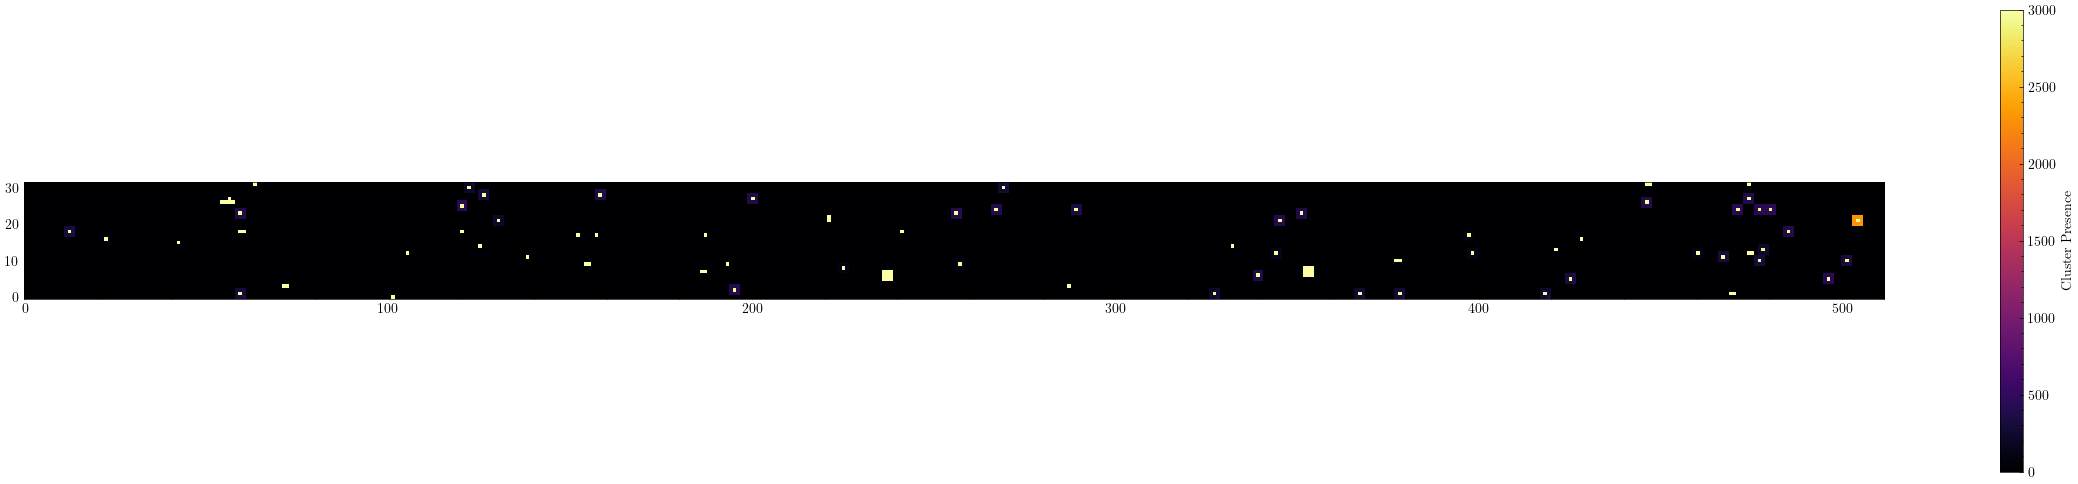

In [309]:
with fits.open(rateints_files[0]) as hdul:
    data = hdul[1].data
    data_slice = data[0, :, :]

mask = np.zeros(data_slice.shape, dtype=int)
for key, value in row_counts.items():
    mask[key[0], key[1]] = value

plt.figure(figsize=(30, 6))
plt.imshow(mask, cmap='inferno', aspect='equal', origin='lower')
plt.colorbar(label="Cluster Presence")
plt.show()

In [310]:
# Replace '-' with NaN to handle non-numeric values
df_numeric = df_labels.replace('-', np.nan)
df_LOW_QE = df_numeric.applymap(lambda x: x if x == 'LOW_QE' else np.nan)
df_DEAD = df_numeric.applymap(lambda x: x if x == 'DEAD' else np.nan)
df_OPEN = df_numeric.applymap(lambda x: x if x == 'OPEN' else np.nan)
df_ADJACENT_OPEN = df_numeric.applymap(lambda x: x if x == 'ADJACENT_OPEN' else np.nan)


# Count non-NaN values in each row
row_counts_LOW_QE = df_LOW_QE.notna().sum(axis=1)
row_counts_DEAD = df_DEAD.notna().sum(axis=1)
row_counts_OPEN = df_OPEN.notna().sum(axis=1)
row_counts_ADJACENT_OPEN = df_ADJACENT_OPEN.notna().sum(axis=1)

/tmp/ipykernel_35075/123949942.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_LOW_QE = df_numeric.applymap(lambda x: x if x == 'LOW_QE' else np.nan)
/tmp/ipykernel_35075/123949942.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_DEAD = df_numeric.applymap(lambda x: x if x == 'DEAD' else np.nan)
/tmp/ipykernel_35075/123949942.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_OPEN = df_numeric.applymap(lambda x: x if x == 'OPEN' else np.nan)
/tmp/ipykernel_35075/123949942.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_ADJACENT_OPEN = df_numeric.applymap(lambda x: x if x == 'ADJACENT_OPEN' else np.nan)


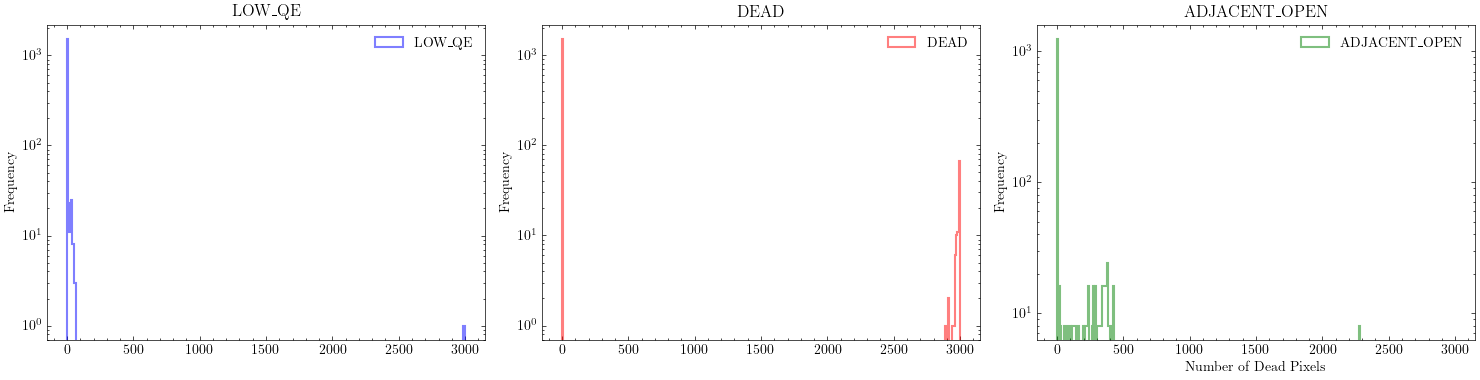

In [326]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

# Plot LOW_QE histogram
axes[0].hist(row_counts_LOW_QE, bins=300, alpha=0.5, label='LOW_QE', color='blue', histtype='step', linewidth=1.5)
axes[0].legend()
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].set_title('LOW_QE')

# Plot DEAD histogram
axes[1].hist(row_counts_DEAD, bins=300, alpha=0.5, label='DEAD', color='red', histtype='step', linewidth=1.5)
axes[1].legend()
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')
axes[1].set_title('DEAD')

# Plot ADJACENT_OPEN histogram
axes[2].hist(row_counts_ADJACENT_OPEN, bins=300, alpha=0.5, label='ADJACENT_OPEN', color='green', histtype='step', linewidth=1.5)
axes[2].legend()
axes[2].set_xlabel('Number of Dead Pixels')
axes[2].set_ylabel('Frequency')
axes[2].set_yscale('log')
axes[2].set_title('ADJACENT_OPEN')

plt.tight_layout()
plt.show()

In [295]:
def interpolate_dead_pixels_simple(data, dead, threshold=1.3, radius=3, iterations=1):
    """
    Interpolates dead pixels in a 2D array using a simple method.
    """
    # make a data copy
    data = data.copy()

    rows, cols = data.shape
    dead_pixels = dead.copy()

    for _ in range(iterations):
        for pixel in dead_pixels:
            x, y = pixel
            # Get the surrounding pixels within the specified radius
            surrounding_pixels = [(i, j) for i in range(max(0, x - radius), min(rows, x + radius + 1))
                                  for j in range(max(0, y - radius), min(cols, y + radius + 1))
                                  if (i, j) != (x, y)]

            # Calculate the mean of the surrounding pixels
            surrounding_values = [data[i, j] for i, j in surrounding_pixels if not np.isnan(data[i, j])]
            if surrounding_values:
                data[x, y] = np.mean(surrounding_values)

    return data

(6058, 32, 512)


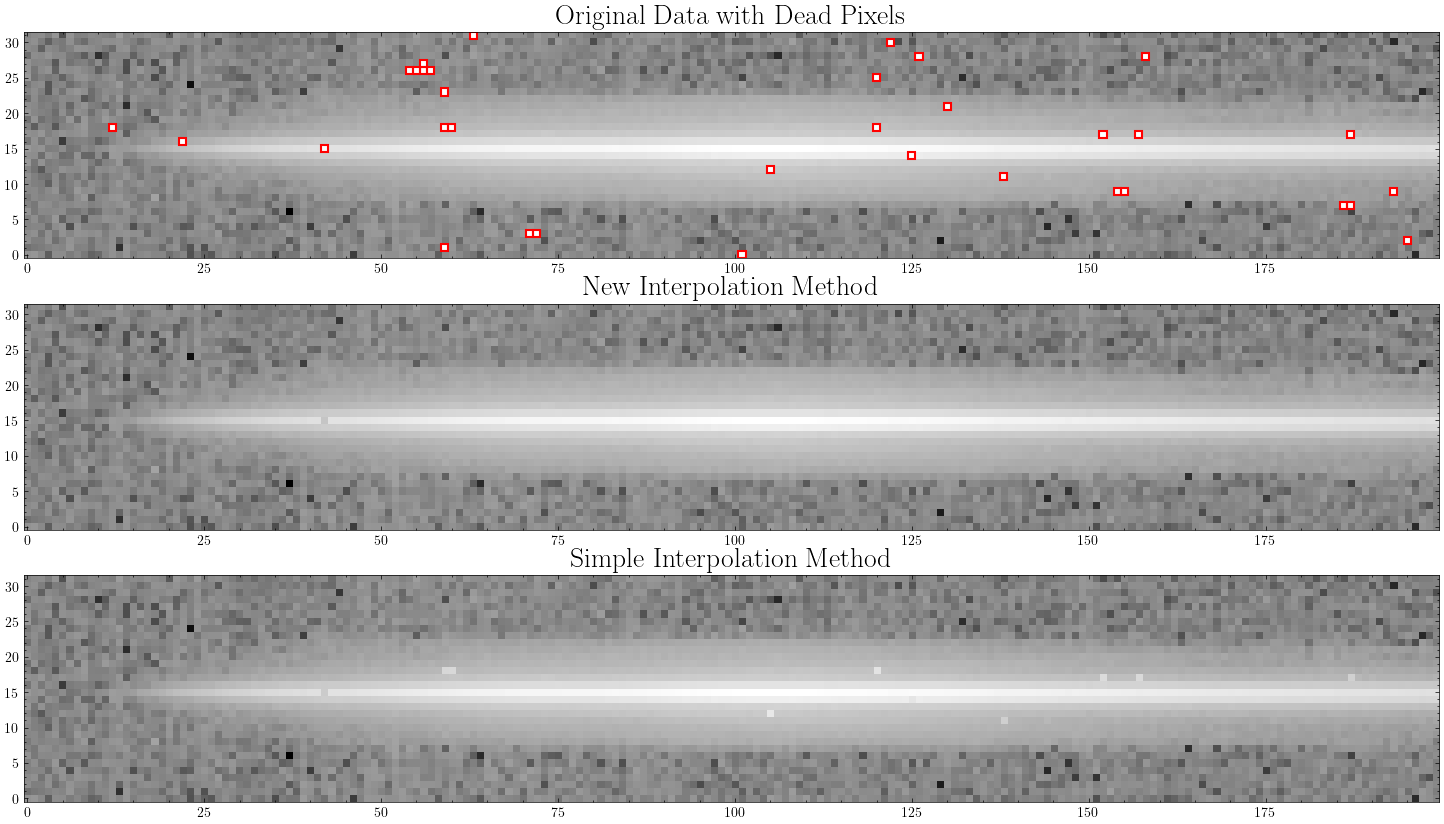

In [ ]:
with fits.open(rateints_files[0]) as hdul:
    data = hdul[1].data
    print(data.shape)
    slice, edge = 5, 200
    data = data[slice, :, :edge]
    dead_pixels = pixels[slice]
    dead_pixels = [pixel for pixel in dead_pixels if pixel[1] < edge]
    
    # Interpolate using both methods
    interpolated_new, confidence = dp.interpolate_dead_pixels(data, dead_pixels, 0.5, 3, 5)
    interpolated_old = interpolate_dead_pixels_simple(data, dead_pixels, 0.5, 3, 3)
    
    # Log-transform the data
    data, interpolated_new = (
        np.log10(abs(data)),
        np.log10(abs(interpolated_new))
    )

    with plt.rc_context({'axes.titlesize': 40}):
        fig, ax = plt.subplots(3, 1, figsize=(28, 10))
        # Original data with dead pixels highlighted
        ax[0].imshow(data[:, :], cmap='grey', aspect='equal', origin='lower')
        for pixel in dead_pixels:
            y, x = pixel  # careful: first index = row (y), second = column (x)
            rect = plt.Rectangle((x - 0.5, y - 0.5), 1, 1, edgecolor='red', facecolor='none', lw=1.5)
            ax[0].add_patch(rect)
        ax[0].set_title("Original Data with Dead Pixels", fontsize=20)
        
        # New interpolation method
        ax[1].imshow(interpolated_new[:, :], cmap='grey', aspect='equal', origin='lower')
        ax[1].set_title("New Interpolation Method", fontsize=20)

        ax[2].imshow(np.log10(abs(interpolated_old[:, :])), cmap='grey', aspect='equal', origin='lower')
        ax[2].set_title("Simple Interpolation Method", fontsize=20)
        
        # Add gridlines
        for axis in ax:
            for i in range(data.shape[0]):
                axis.axhline(i + 0.5, color='red', lw=0)
            for i in range(data.shape[1]):
                axis.axvline(i + 0.5, color='red', lw=0)

        #plt.savefig(f"../Presentations/Introduction Presentation/Pictures/interpolation.pdf", bbox_inches='tight', dpi=300)
        plt.show()

In [21]:
def plot_fits(file):
    with fits.open(file) as hdul:
        data = hdul[1].data
        #data[:, 15:20, 25:30] = np.nan
        #data = np.nansum(data, axis=0)
        data = np.nansum(data, axis=0)
        # Normalize the data
        data = data / np.nanmax(data)
        data = data[:, 400:]
        # take only data where it is smaller than 0.05
        #data = np.log10(abs(data))

        data = np.log10(abs(data))


        plt.figure(figsize=(9, 2))  # Make the figure square
        plt.imshow(data[:, :], cmap='rainbow', aspect='equal', origin='lower')
        plt.xticks([])  # Remove x-axis ticks
        plt.yticks([])  # Remove y-axis ticks
        cbar = plt.colorbar()
        cbar.set_label('Log Counts')
        #plt.title(file)
        #plt.savefig(f"../Presentations/Introduction Presentation/Pictures/dead_pixel.pdf", bbox_inches='tight', dpi=300)
        plt.show()

# Plot each file
for file in interpolated_files:
    plot_fits(file)

for file in rateints_files:
    plot_fits(file)


NameError: name 'interpolated_files' is not defined

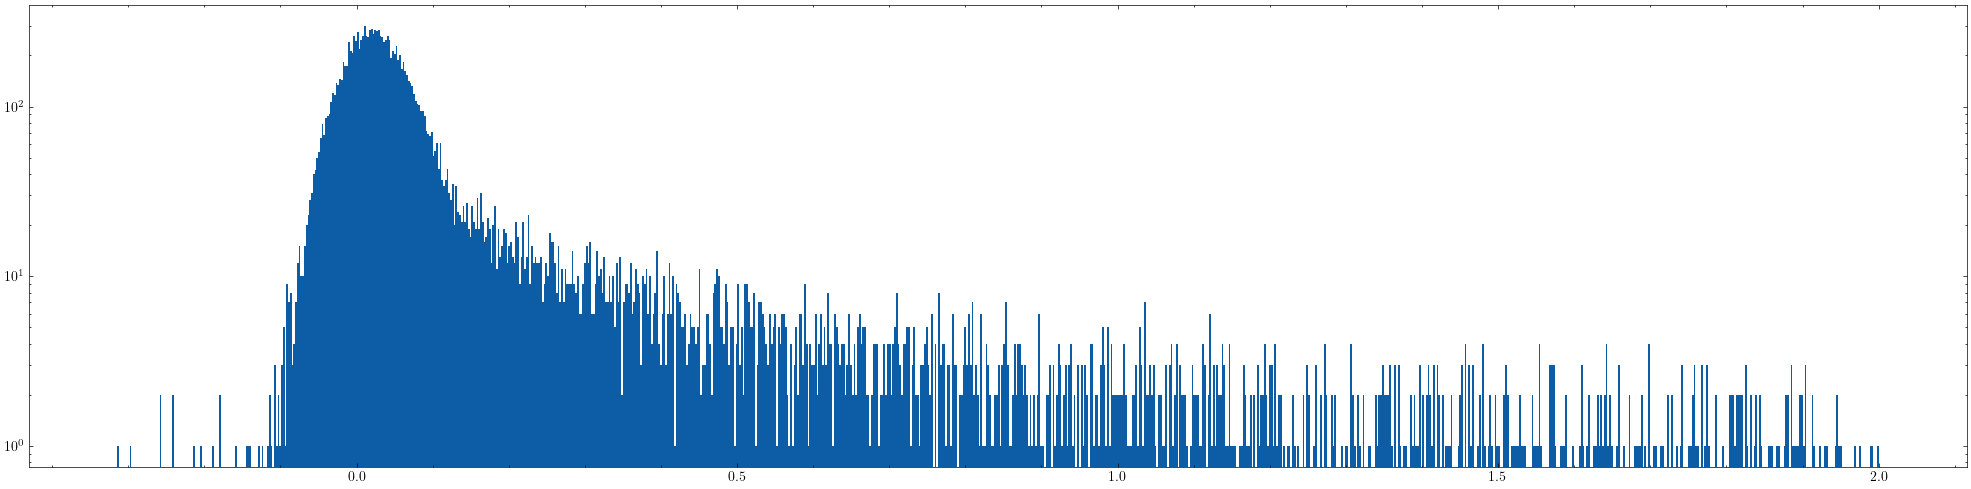

In [ ]:
with fits.open(rateints_files[0]) as hdul:
    data = hdul[1].data

data = data[0, :, :]

#flatten the data
data = data.flatten()
#

data = data / np.nanmean(data)
data = data[data <= 2]

fig, ax = plt.subplots(figsize=(25, 6))
ax.hist(data, bins=1000, log=True)
ax.set_yscale('log')



ValueError: need at least one array to concatenate

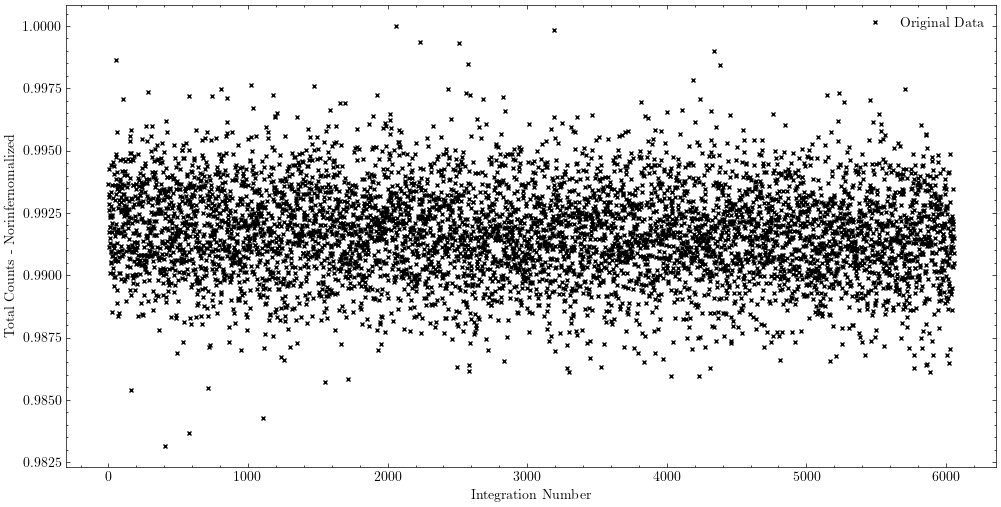

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

total_data = []
for file in rateints_files:
    with fits.open(file) as hdul:
        data = hdul[1].data
        # slice the data form 10 to 20 on axis 2 and keep axis 1 and 3 untouched
        data = data[:, 13:17, :]
        data = np.nansum(data, axis=(1, 2)) # Sum over the first two axes
        data = data / np.nanmax(data) # Normalize the data        

        total_data.append(data)
        
total_data = np.concatenate(total_data)
ax.plot(total_data, 'x', ms=3, color='black')
ax.set_xlabel('Integration Number')
ax.set_ylabel('Total Counts - Norinfernomalized')
ax.legend(['Original Data'])

total_data = []
for file in interpolated_files:
    with fits.open(file) as hdul:
        data = hdul[1].data
        # slice the data form 10 to 20 on axis 2 and keep axis 1 and 3 untouched
        data = data[:, 13:17, :]
        data = np.nansum(data, axis=(1, 2)) # Sum over the first two axes
        data = data / np.nanmax(data) # Normalize the data        
        total_data.append(data)
        
total_data = np.concatenate(total_data)
ax.plot(total_data, 'x', ms=3, color='blue')
ax.set_xlabel('Integration Number')
ax.set_ylabel('Total Counts - Norinfernomalized')
ax.legend(['Original Data', 'Interpolated Data'])

plt.show()